# **I. DATA LOAD & PREPROCESSING**

1. Install Library

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install workdays
!pip install tensorflow keras
!pip install hurst
!pip install attention
!pip install sns

  Preparing metadata (setup.py) ... done
  Created wheel for workdays: filename=workdays-1.4-py3-none-any.whl size=2662 sha256=3d44d3962698ad813d1a039fe0b495b3d791b55bbf3d137cb8c6028f57a154ae
  Stored in directory: /root/.cache/pip/wheels/28/95/3c/4bcba898c71ab52da62e0853296bc29d88401053270a3eba83
Successfully built workdays
  Preparing metadata (setup.py) ... done
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2639 sha256=36c1053d8a2c36a48a67bc0c3eaf9262da3fcae2d93c5ac70ac7d4ca56b7980b
  Stored in directory: /root/.cache/pip/wheels/26/ac/4b/7743e50a108f4a12a07e0e257dbecefc884a953125a6e1b48f
Successfully built sns


2. Data Load

In [4]:
# ==== ONE-CELL UNIVERSAL LOADER: Local -> URL -> Kaggle ====
!pip -q install gdown

import os, re, glob, sys, subprocess, requests, pandas as pd, hashlib

DATA_DIR  = "data"; os.makedirs(DATA_DIR, exist_ok=True)
DATA_FILE = "credit_risk_dataset.csv"
DATA_PATH = f"{DATA_DIR}/{DATA_FILE}"

#Link from github
DATA_URL = "https://raw.githubusercontent.com/thithuphuongnguyen-dotcom/StockPrice/refs/heads/main/Hoa%20Phat%20Group%20JSC%20Stock%20Price%20History.csv"


EXPECTED_SHA256 = ""

KAGGLE_DATASET = "laotse/credit-risk-dataset"  # fallback if need

def sha256_file(p):
    h = hashlib.sha256()
    with open(p,'rb') as f:
        for c in iter(lambda: f.read(1<<20), b''): h.update(c)
    return h.hexdigest()

def from_local():
    return os.path.exists(DATA_PATH)

def from_url():
    if not DATA_URL: return False
    url = DATA_URL.strip()

    #If it’s Google Drive -> use gdown (stable, bypass confirmation/quota)
    if "drive.google.com" in url:
        m = re.search(r"/d/([A-Za-z0-9_-]{10,})", url) or re.search(r"[?&]id=([A-Za-z0-9_-]{10,})", url)
        if not m:
            print("❌ Không trích được FILE_ID từ DATA_URL Drive."); return False
        file_id = m.group(1)
        try:
            import gdown  # noqa
        except Exception:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "gdown"], check=True)
            import gdown
        gdown.download(f"https://drive.google.com/uc?id={file_id}", DATA_PATH, quiet=False)
        return os.path.exists(DATA_PATH)

    # URL from(GitHub raw, S3, Dropbox…)
    r = requests.get(url, timeout=60, allow_redirects=True)
    r.raise_for_status()
    open(DATA_PATH, "wb").write(r.content)
    return True

def from_kaggle():
    kj = os.path.expanduser("~/.kaggle/kaggle.json")
    if not os.path.exists(kj):
        print("⚠️ Not found ~/.kaggle/kaggle.json — leave Kaggle.")
        return False
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi(); api.authenticate()
    api.dataset_download_files(KAGGLE_DATASET, path=DATA_DIR, unzip=True)
    cands = [p for p in glob.glob(f"{DATA_DIR}/*.csv")]
    if cands and not os.path.exists(DATA_PATH):
        os.replace(cands[0], DATA_PATH)
    return os.path.exists(DATA_PATH)

ok = from_local() or from_url() or from_kaggle()
if not ok:
    raise SystemExit("No data available. Place the CSV in ./data/, or fill in DATA_URL, or upload kaggle.json and then Run all.")

if EXPECTED_SHA256:
    cur = sha256_file(DATA_PATH); print("SHA256:", cur)
    assert cur == EXPECTED_SHA256, "Hash mismatch archived"


In [5]:
df = pd.read_csv(DATA_PATH)
print("✅ Loaded:", df.shape, "| CSV:", DATA_PATH)
df.head()

✅ Loaded: (4448, 7) | CSV: data/credit_risk_dataset.csv


,Date,Price,Open,High,Low,Vol.,Change %
0,09/24/2025,"29,050.0","28,650.0","29,050.0","28,250.0",30.74M,1.40%
1,09/23/2025,"28,650.0","28,550.0","28,850.0","28,450.0",24.90M,0.88%
2,09/22/2025,"28,400.0","29,250.0","29,250.0","28,300.0",66.07M,-2.91%
3,09/19/2025,"29,250.0","29,300.0","29,400.0","28,800.0",45.02M,0.34%
4,09/18/2025,"29,150.0","29,350.0","29,400.0","28,600.0",75.69M,-0.17%


3. Data Preprocessing

In [6]:
#3.1. Convert Volume

def convert_volume(x):
    if isinstance(x, str):
        x = x.replace(",", "").strip()
        if x.endswith("K"):
            return float(x[:-1]) * 1_000
        elif x.endswith("M"):
            return float(x[:-1]) * 1_000_000
        elif x.endswith("B"):
            return float(x[:-1]) * 1_000_000_000
        else:
            return pd.to_numeric(x, errors="coerce")
    return x

df["Vol."] = df["Vol."].apply(convert_volume)

#========================
#3.2. Covert Date

df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df = df.dropna(subset=["Date"])
df = df.sort_values("Date")
df = df.set_index("Date")

#========================
#3.3. Covert Numeric Features

cols_numeric = ["Price", "Open", "High", "Low"]

for col in cols_numeric:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("-", "", regex=False)
        .astype(float)
    )

df["Change %"] = (
    df["Change %"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

print(df.dtypes)
print(df.shape)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object
(4448, 6)


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2007-11-16,1916.6,1916.6,1916.6,1916.6,11080000.0,-4.72
2007-11-19,1821.6,1821.6,1821.6,1821.6,5370000.0,-4.96
2007-11-20,1742.4,1742.4,1742.4,1742.4,2620000.0,-4.35
2007-11-21,1805.8,1663.2,1805.8,1663.2,32450000.0,3.64
2007-11-22,1805.8,1805.8,1805.8,1805.8,11860000.0,0.00


In [ ]:
#3.4. Drop Nonbusiness days

from pandas.tseries.offsets import CustomBusinessDay

def drop_non_busdays(df, holidays=None):
    if holidays is None:
        holidays = []
    custom_bd = CustomBusinessDay(holidays=holidays)
    df = df[df.index.to_series().map(lambda d: d in pd.date_range(df.index.min(), df.index.max(), freq=custom_bd))]
    return df

In [ ]:
#3.5. DF for modelling
data = df[['Price']]

# **II. BASE MODEL**

Naive Forecast - The most basic model is used to be the Benchmark.

In [ ]:
# 1. Naive forecast: Price today = Price yesterday
naive_forecast = data['Price'].shift(1).dropna()

# 2. Calculate validation price
y_actual = data['Price'].iloc[-60:]  # ví dụ lấy 60 ngày cuối
y_pred_naive = naive_forecast.iloc[-60:]
y_pred_naive.index = y_actual.index

# 3. Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2_naive = r2_score(y_actual, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_actual, y_pred_naive))
mae_naive = mean_absolute_error(y_actual, y_pred_naive)
mape_naive = np.mean(np.abs((y_actual - y_pred_naive) / y_actual.replace(0, np.nan))) * 100

print(f"Naive R²: {r2_naive:.4f}")
print(f"Naive RMSE: {rmse_naive:.2f}")
print(f"Naive MAE: {mae_naive:.2f}")
print(f"Naive MAPE : {mape_naive:.2f}%")



Naive R²: 0.9039
Naive RMSE: 586.34
Naive MAE: 432.50
Naive MAPE : 1.59%


# **III. LSTM MODEL**

1. Import Library

In [ ]:
from numpy import array
from matplotlib import pyplot as plt
import statsmodels.api as smt
from datetime import datetime as dt
import datetime
from datetime import timedelta
from datetime import datetime
from hurst import compute_Hc, random_walk
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from attention import Attention
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from numpy import array
import workdays as wd
import tensorflow.keras
import sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

2. Split Dataset

In [ ]:
# Split Train/Test Data

Train_Set = data[0:-60] #I was intended to do more forecast with more days than 15, so I choose 60.
Test_Set = data[-60:]
Train_Set

,Price
Date,
2007-11-16,1916.6
2007-11-19,1821.6
2007-11-20,1742.4
2007-11-21,1805.8
2007-11-22,1805.8
...,...
2025-06-24,22500.0
2025-06-25,22666.7
2025-06-26,22800.0


In [ ]:
Test_Set

,Price
Date,
2025-07-01,22650.0
2025-07-02,22900.0
2025-07-03,23100.0
2025-07-04,23250.0
2025-07-07,23600.0
2025-07-08,24700.0
2025-07-09,24750.0
2025-07-10,25150.0
2025-07-11,26000.0


3. Set up Training Model

In [ ]:
def Train_Model(Train_Set, time_step, val_days, epoch, fc_days):

    # ===============================
    # 1️⃣ DATA PREPROCESSING
    # ===============================
    # Scale data between 0 and 1 to speed up convergence and improve stability
    scaler=MinMaxScaler(feature_range=(0,1))
    Train_Set_scaler=scaler.fit_transform(np.array(Train_Set).reshape(-1,1))

    # Split training and validation based on time sequence
    training_size = len(Train_Set) - time_step - val_days
    Train_data, Val_data = Train_Set_scaler[0:training_size,:], Train_Set_scaler[training_size::,:1]

    # ===============================
    # 2️⃣ CREATE SUPERVISED SEQUENCES
    # ===============================
    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, time_step):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step):
            a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)

    # Generate training and validation datasets
    X_train, Y_train = create_dataset(Train_data, time_step)
    X_val, Y_val = create_dataset(Val_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)

    # ===============================
    # 3️⃣ MODEL ARCHITECTURE
    # ===============================
    # Sequential LSTM model captures temporal dependencies
    model=Sequential()
    model.add(LSTM(64, return_sequences=False,input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',optimizer='adam')

    # ===============================
    # 4️⃣ TRAINING PROCESS
    # ===============================
    # Simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    mc = ModelCheckpoint('./best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    # Train the model on training set and validate on hold-out data
    history = model.fit(X_train, Y_train,
                    validation_data=(X_val,Y_val),
                    epochs= epoch,
                    batch_size=64,
                    verbose=1,
                    callbacks = [es, mc])
    saved_model = tf.keras.models.load_model("./best_model_.h5")

    # ===============================
    # 5️⃣ PREDICTIONS AND PERFORMANCE
    # ===============================
    # Predict on training and validation data
    Train_predict= model.predict(X_train)
    Val_predict= model.predict(X_val)
    tmp_Val_predict = Val_predict

    # Inverse transform to original price scale
    Train_predict=scaler.inverse_transform(Train_predict)
    Val_predict=scaler.inverse_transform(Val_predict)

    # Compute RMSE for validation data
    RMSE = math.sqrt(mean_squared_error(Y_val,tmp_Val_predict))

    # Create dataframe for validation comparison
    Val_forecast = Train_Set[-val_days-1:-1].copy()
    Val_forecast['Predictions'] = Val_predict

    # Define Mean Absolute Percentage Error (MAPE)
    def cal_MAPE(x):
        tmp = np.abs((x['Price'] - x['Predictions'])) / x['Price']
        tmp[np.isinf(tmp)] = 0
        return np.mean(tmp)

    MAPE = cal_MAPE(Val_forecast)

    # ===============================
    # 6️⃣ MULTI-STEP FORECAST (15 DAYS)
    # ===============================
    # Use last 60 days of training data as seed input for future prediction

    x_input=Train_Set_scaler[-time_step:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    output=[]
    n_steps= time_step
    i=0

    # Predict recursively for fc_days (15 trading days)
    while(i < fc_days):

        if(len(temp_input)> time_step):
            x_input=np.array(temp_input[1:])
            x_input= x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            output.extend(yhat.tolist())
            i=i+1

    # ===============================
    # 7️⃣ FORECAST OUTPUT AND SAVE MODEL
    # ===============================
    # Create date index for next 15 trading days
    start = Train_Set.index[-1] + timedelta(days=1)
    test_forecast = pd.DataFrame({'Date':pd.date_range(start, periods=45, freq='D')})
    test_forecast = test_forecast.set_index('Date')
    test_forecast = drop_non_busdays(test_forecast)
    test_forecast = test_forecast[:15]
    test_forecast['Predictions'] = scaler.inverse_transform(output)

    # Include last actual data point for continuity
    line = pd.to_datetime(Train_Set.index[-1], format="%Y-%m-%d")
    new_row = pd.DataFrame(Train_Set['Price'][-1], columns= ["Predictions"], index=[line])
    test_forecast = pd.concat([test_forecast, pd.DataFrame(new_row)], ignore_index=False)
    test_forecast = test_forecast.sort_index()

    # Save model and scaler for reuse
    import joblib
    joblib.dump(scaler, "/content/drive/My Drive/Advanced Algorithms - ML/scaler.pkl")
    model.save('/content/drive/My Drive/Advanced Algorithms - ML/best_model_.h5')

    # Return validation and test forecasts, RMSE, MAPE, and training history
    return  Val_forecast, test_forecast, RMSE, MAPE, history

4. Training Execution

In [ ]:
Val_forecast, test_forecast, RMSE, MAPE, history = \
    Train_Model(Train_Set = Train_Set, time_step = 60, val_days = 60, epoch = 500, fc_days = 15)

Epoch 1/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344
Epoch 1: val_loss improved from inf to 0.00114, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0324 - val_loss: 0.0011
Epoch 2/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6999e-04
Epoch 2: val_loss improved from 0.00114 to 0.00085, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6306e-04 - val_loss: 8.4731e-04
Epoch 3/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4152e-04
Epoch 3: val_loss improved from 0.00085 to 0.00083, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4044e-04 - val_loss: 8.2511e-04
Epoch 4/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8408e-04
Epoch 4: val_loss did not improve from 0.00083
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8105e-04 - val_loss: 8.9273e-04
Epoch 5/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7384e-04
Epoch 5: val_loss improved from 0.00083 to 0.00080, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7196e-04 - val_loss: 8.0066e-04
Epoch 6/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1133e-04
Epoch 6: val_loss did not improve from 0.00080
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0907e-04 - val_loss: 9.0589e-04
Epoch 7/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3876e-04
Epoch 7: val_loss did not improve from 0.00080
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4001e-04 - val_loss: 8.2933e-04
Epoch 8/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7842e-04
Epoch 8: val_loss did not improve from 0.00080
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7868e-04 - val_loss: 8.8643e-04
Epoch 9/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6133e-04
Epoch 9: val_loss improved from 0.00080 to 0.00079, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6177e-04 - val_loss: 7.9287e-04
Epoch 10/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8847e-04
Epoch 10: val_loss did not improve from 0.00079
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8731e-04 - val_loss: 9.6785e-04
Epoch 11/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5740e-04
Epoch 11: val_loss did not improve from 0.00079
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5777e-04 - val_loss: 8.1492e-04
Epoch 12/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0398e-04
Epoch 12: val_loss did not improve from 0.00079
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0406e-04 - val_loss: 9.9047e-04
Epoch 13/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5123e-04
Epoch 13: val_loss improved from 0.00079 to 0.00076, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4981e-04 - val_loss: 7.5902e-04
Epoch 14/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6151e-04
Epoch 14: val_loss did not improve from 0.00076
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6543e-04 - val_loss: 9.6532e-04
Epoch 15/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1990e-04
Epoch 15: val_loss did not improve from 0.00076
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2004e-04 - val_loss: 8.0722e-04
Epoch 16/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9697e-04
Epoch 16: val_loss did not improve from 0.00076
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0090e-04 - val_loss: 8.2700e-04
Epoch 17/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8346e-04
Epoch 17: val_loss did not improve from 0.00076
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8516e-04 - val_loss: 8.9884e-04
Epoch 18/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2072e-04
Epoch 18: val_loss improved from 0.00076 to 0.00

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1824e-04 - val_loss: 7.3339e-04
Epoch 19/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1588e-04
Epoch 19: val_loss improved from 0.00073 to 0.00072, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1531e-04 - val_loss: 7.1686e-04
Epoch 20/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5160e-04
Epoch 20: val_loss did not improve from 0.00072
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5293e-04 - val_loss: 7.4774e-04
Epoch 21/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9046e-04
Epoch 21: val_loss did not improve from 0.00072
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8828e-04 - val_loss: 7.4074e-04
Epoch 22/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6049e-04
Epoch 22: val_loss did not improve from 0.00072
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6171e-04 - val_loss: 9.8311e-04
Epoch 23/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9451e-04
Epoch 23: val_loss did not improve from 0.00072
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9348e-04 - val_loss: 9.2509e-04
Epoch 24/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7257e-04
Epoch 24: val_loss improved from 0.00072 to 0.00

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7174e-04 - val_loss: 6.9582e-04
Epoch 25/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6262e-04
Epoch 25: val_loss did not improve from 0.00070
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6018e-04 - val_loss: 7.0448e-04
Epoch 26/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4152e-04
Epoch 26: val_loss improved from 0.00070 to 0.00068, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4145e-04 - val_loss: 6.8321e-04
Epoch 27/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3867e-04
Epoch 27: val_loss did not improve from 0.00068
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3708e-04 - val_loss: 7.8747e-04
Epoch 28/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4520e-04
Epoch 28: val_loss did not improve from 0.00068
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4589e-04 - val_loss: 0.0011
Epoch 29/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4535e-04
Epoch 29: val_loss improved from 0.00068 to 0.00068, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4505e-04 - val_loss: 6.7990e-04
Epoch 30/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8822e-04
Epoch 30: val_loss did not improve from 0.00068
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8941e-04 - val_loss: 6.9481e-04
Epoch 31/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1863e-04
Epoch 31: val_loss improved from 0.00068 to 0.00068, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1930e-04 - val_loss: 6.7843e-04
Epoch 32/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8731e-04
Epoch 32: val_loss did not improve from 0.00068
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8823e-04 - val_loss: 0.0012
Epoch 33/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2012e-04
Epoch 33: val_loss improved from 0.00068 to 0.00065, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2049e-04 - val_loss: 6.4819e-04
Epoch 34/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6228e-04
Epoch 34: val_loss did not improve from 0.00065
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6000e-04 - val_loss: 6.6407e-04
Epoch 35/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8959e-04
Epoch 35: val_loss did not improve from 0.00065
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9086e-04 - val_loss: 6.7378e-04
Epoch 36/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1090e-04
Epoch 36: val_loss did not improve from 0.00065
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1155e-04 - val_loss: 6.4976e-04
Epoch 37/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3995e-04
Epoch 37: val_loss did not improve from 0.00065
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3787e-04 - val_loss: 9.4637e-04
Epoch 38/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0410e-04
Epoch 38: val_loss did not improve from 0.00065


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7877e-04 - val_loss: 6.2454e-04
Epoch 40/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9733e-04
Epoch 40: val_loss did not improve from 0.00062
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9768e-04 - val_loss: 8.5745e-04
Epoch 41/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0283e-04
Epoch 41: val_loss improved from 0.00062 to 0.00060, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0190e-04 - val_loss: 6.0375e-04
Epoch 42/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8140e-04
Epoch 42: val_loss improved from 0.00060 to 0.00060, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8187e-04 - val_loss: 5.9739e-04
Epoch 43/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0237e-04
Epoch 43: val_loss did not improve from 0.00060
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0197e-04 - val_loss: 6.4928e-04
Epoch 44/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4549e-04
Epoch 44: val_loss did not improve from 0.00060
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4750e-04 - val_loss: 7.3914e-04
Epoch 45/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7093e-04
Epoch 45: val_loss improved from 0.00060 to 0.00057, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7104e-04 - val_loss: 5.6991e-04
Epoch 46/500
59/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8309e-04
Epoch 46: val_loss did not improve from 0.00057
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8182e-04 - val_loss: 6.0469e-04
Epoch 47/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7416e-04
Epoch 47: val_loss did not improve from 0.00057
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7331e-04 - val_loss: 6.4447e-04
Epoch 48/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1276e-04
Epoch 48: val_loss did not improve from 0.00057
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0908e-04 - val_loss: 5.7576e-04
Epoch 49/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8121e-04
Epoch 49: val_loss did not improve from 0.00057
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8018e-04 - val_loss: 6.2454e-04
Epoch 50/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4894e-04
Epoch 50: val_loss improved from 0.00057 to 0.00

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4995e-04 - val_loss: 5.6946e-04
Epoch 51/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5868e-04
Epoch 51: val_loss improved from 0.00057 to 0.00054, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5816e-04 - val_loss: 5.4379e-04
Epoch 52/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7846e-04
Epoch 52: val_loss improved from 0.00054 to 0.00054, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7860e-04 - val_loss: 5.4101e-04
Epoch 53/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6739e-04
Epoch 53: val_loss did not improve from 0.00054
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6688e-04 - val_loss: 6.5770e-04
Epoch 54/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8970e-04
Epoch 54: val_loss improved from 0.00054 to 0.00053, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8833e-04 - val_loss: 5.2859e-04
Epoch 55/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3976e-04
Epoch 55: val_loss did not improve from 0.00053
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3993e-04 - val_loss: 6.1180e-04
Epoch 56/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3796e-04
Epoch 56: val_loss improved from 0.00053 to 0.00052, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3855e-04 - val_loss: 5.2423e-04
Epoch 57/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5028e-04
Epoch 57: val_loss did not improve from 0.00052
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5211e-04 - val_loss: 7.7940e-04
Epoch 58/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8678e-04
Epoch 58: val_loss improved from 0.00052 to 0.00051, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8364e-04 - val_loss: 5.0636e-04
Epoch 59/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1693e-04
Epoch 59: val_loss improved from 0.00051 to 0.00050, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1874e-04 - val_loss: 5.0206e-04
Epoch 60/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4600e-04
Epoch 60: val_loss did not improve from 0.00050
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4586e-04 - val_loss: 5.3846e-04
Epoch 61/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5589e-04
Epoch 61: val_loss did not improve from 0.00050
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5516e-04 - val_loss: 5.0814e-04
Epoch 62/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7461e-04
Epoch 62: val_loss improved from 0.00050 to 0.00050, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7221e-04 - val_loss: 4.9645e-04
Epoch 63/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4444e-04
Epoch 63: val_loss improved from 0.00050 to 0.00048, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4535e-04 - val_loss: 4.8139e-04
Epoch 64/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2212e-04
Epoch 64: val_loss did not improve from 0.00048
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2207e-04 - val_loss: 5.4302e-04
Epoch 65/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2084e-04
Epoch 65: val_loss did not improve from 0.00048
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2130e-04 - val_loss: 4.8608e-04
Epoch 66/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3000e-04
Epoch 66: val_loss improved from 0.00048 to 0.00046, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2952e-04 - val_loss: 4.6197e-04
Epoch 67/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4355e-04
Epoch 67: val_loss did not improve from 0.00046
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4294e-04 - val_loss: 4.6356e-04
Epoch 68/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7105e-04
Epoch 68: val_loss improved from 0.00046 to 0.00046, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7024e-04 - val_loss: 4.6072e-04
Epoch 69/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0703e-04
Epoch 69: val_loss did not improve from 0.00046
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0745e-04 - val_loss: 5.1837e-04
Epoch 70/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4586e-04
Epoch 70: val_loss improved from 0.00046 to 0.00044, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4524e-04 - val_loss: 4.4419e-04
Epoch 71/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1014e-04
Epoch 71: val_loss did not improve from 0.00044
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1051e-04 - val_loss: 4.8702e-04
Epoch 72/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3258e-04
Epoch 72: val_loss did not improve from 0.00044
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3280e-04 - val_loss: 5.3511e-04
Epoch 73/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4318e-04
Epoch 73: val_loss improved from 0.00044 to 0.00043, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4279e-04 - val_loss: 4.2756e-04
Epoch 74/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3552e-04
Epoch 74: val_loss did not improve from 0.00043
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3417e-04 - val_loss: 4.8500e-04
Epoch 75/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0710e-04
Epoch 75: val_loss did not improve from 0.00043
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0803e-04 - val_loss: 6.1381e-04
Epoch 76/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9633e-04
Epoch 76: val_loss improved from 0.00043 to 0.00041, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9788e-04 - val_loss: 4.0889e-04
Epoch 77/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8033e-04
Epoch 77: val_loss improved from 0.00041 to 0.00041, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8220e-04 - val_loss: 4.0661e-04
Epoch 78/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2000e-04
Epoch 78: val_loss did not improve from 0.00041
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1950e-04 - val_loss: 4.0770e-04
Epoch 79/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1321e-04
Epoch 79: val_loss did not improve from 0.00041
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1317e-04 - val_loss: 4.5628e-04
Epoch 80/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2664e-04
Epoch 80: val_loss did not improve from 0.00041
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2634e-04 - val_loss: 5.4467e-04
Epoch 81/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1092e-04
Epoch 81: val_loss did not improve from 0.00041
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1108e-04 - val_loss: 4.5737e-04
Epoch 82/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3836e-04
Epoch 82: val_loss did not improve from 0.00041


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1307e-04 - val_loss: 3.9709e-04
Epoch 84/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0689e-04
Epoch 84: val_loss improved from 0.00040 to 0.00039, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0699e-04 - val_loss: 3.8532e-04
Epoch 85/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9107e-04
Epoch 85: val_loss did not improve from 0.00039
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9150e-04 - val_loss: 4.2936e-04
Epoch 86/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1886e-04
Epoch 86: val_loss did not improve from 0.00039
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1858e-04 - val_loss: 4.9416e-04
Epoch 87/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0014e-04
Epoch 87: val_loss did not improve from 0.00039
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9968e-04 - val_loss: 4.5443e-04
Epoch 88/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0709e-04
Epoch 88: val_loss improved from 0.00039 to 0.00038, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0650e-04 - val_loss: 3.7843e-04
Epoch 89/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4398e-04
Epoch 89: val_loss improved from 0.00038 to 0.00036, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4253e-04 - val_loss: 3.5722e-04
Epoch 90/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1477e-04
Epoch 90: val_loss did not improve from 0.00036
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1476e-04 - val_loss: 4.2842e-04
Epoch 91/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9910e-04
Epoch 91: val_loss did not improve from 0.00036
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9927e-04 - val_loss: 3.6320e-04
Epoch 92/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1114e-04
Epoch 92: val_loss did not improve from 0.00036
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1125e-04 - val_loss: 3.7142e-04
Epoch 93/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0544e-04
Epoch 93: val_loss improved from 0.00036 to 0.00035, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0529e-04 - val_loss: 3.4982e-04
Epoch 94/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9371e-04
Epoch 94: val_loss did not improve from 0.00035
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9409e-04 - val_loss: 3.9973e-04
Epoch 95/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6923e-04
Epoch 95: val_loss did not improve from 0.00035
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7119e-04 - val_loss: 3.5036e-04
Epoch 96/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8928e-04
Epoch 96: val_loss improved from 0.00035 to 0.00034, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8964e-04 - val_loss: 3.3715e-04
Epoch 97/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9965e-04
Epoch 97: val_loss improved from 0.00034 to 0.00033, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9989e-04 - val_loss: 3.2528e-04
Epoch 98/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8376e-04
Epoch 98: val_loss did not improve from 0.00033
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8377e-04 - val_loss: 3.6842e-04
Epoch 99/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1868e-04
Epoch 99: val_loss improved from 0.00033 to 0.00032, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1745e-04 - val_loss: 3.2067e-04
Epoch 100/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0421e-04
Epoch 100: val_loss did not improve from 0.00032
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0367e-04 - val_loss: 3.3699e-04
Epoch 101/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8418e-04
Epoch 101: val_loss did not improve from 0.00032
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8439e-04 - val_loss: 3.3868e-04
Epoch 102/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8535e-04
Epoch 102: val_loss improved from 0.00032 to 0.00031, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8564e-04 - val_loss: 3.1246e-04
Epoch 103/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7509e-04
Epoch 103: val_loss did not improve from 0.00031
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7697e-04 - val_loss: 3.9308e-04
Epoch 104/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1734e-04
Epoch 104: val_loss did not improve from 0.00031
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1647e-04 - val_loss: 3.1894e-04
Epoch 105/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6940e-04
Epoch 105: val_loss did not improve from 0.00031
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7132e-04 - val_loss: 3.1375e-04
Epoch 106/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1295e-04
Epoch 106: val_loss improved from 0.00031 to 0.00031, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1214e-04 - val_loss: 3.0960e-04
Epoch 107/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2076e-04
Epoch 107: val_loss did not improve from 0.00031
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1983e-04 - val_loss: 3.7422e-04
Epoch 108/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1568e-04
Epoch 108: val_loss improved from 0.00031 to 0.00031, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1639e-04 - val_loss: 3.0841e-04
Epoch 109/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0322e-04
Epoch 109: val_loss did not improve from 0.00031
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0295e-04 - val_loss: 3.2020e-04
Epoch 110/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1061e-04
Epoch 110: val_loss did not improve from 0.00031
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1044e-04 - val_loss: 3.2129e-04
Epoch 111/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1668e-04
Epoch 111: val_loss improved from 0.00031 to 0.00029, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1613e-04 - val_loss: 2.8943e-04
Epoch 112/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0055e-04
Epoch 112: val_loss did not improve from 0.00029
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0070e-04 - val_loss: 2.9880e-04
Epoch 113/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0233e-04
Epoch 113: val_loss did not improve from 0.00029
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0250e-04 - val_loss: 3.2231e-04
Epoch 114/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9727e-04
Epoch 114: val_loss improved from 0.00029 to 0.00028, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9708e-04 - val_loss: 2.7946e-04
Epoch 115/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9659e-04
Epoch 115: val_loss did not improve from 0.00028
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9695e-04 - val_loss: 2.8845e-04
Epoch 116/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8263e-04
Epoch 116: val_loss did not improve from 0.00028
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8308e-04 - val_loss: 3.2763e-04
Epoch 117/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9256e-04
Epoch 117: val_loss did not improve from 0.00028
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9178e-04 - val_loss: 3.1554e-04
Epoch 118/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1484e-04
Epoch 118: val_loss improved from 0.00028 to 0.00027, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1451e-04 - val_loss: 2.7015e-04
Epoch 119/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8618e-04
Epoch 119: val_loss did not improve from 0.00027
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8596e-04 - val_loss: 2.8610e-04
Epoch 120/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7713e-04
Epoch 120: val_loss did not improve from 0.00027
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7739e-04 - val_loss: 3.4596e-04
Epoch 121/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9727e-04
Epoch 121: val_loss did not improve from 0.00027
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9668e-04 - val_loss: 3.6104e-04
Epoch 122/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9905e-04
Epoch 122: val_loss improved from 0.00027 to 0.00026, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9820e-04 - val_loss: 2.5958e-04
Epoch 123/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6619e-04
Epoch 123: val_loss did not improve from 0.00026
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6693e-04 - val_loss: 2.9368e-04
Epoch 124/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9776e-04
Epoch 124: val_loss did not improve from 0.00026
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9783e-04 - val_loss: 2.8914e-04
Epoch 125/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9871e-04
Epoch 125: val_loss did not improve from 0.00026
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9825e-04 - val_loss: 2.6286e-04
Epoch 126/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9541e-04
Epoch 126: val_loss did not improve from 0.00026
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9537e-04 - val_loss: 3.4451e-04
Epoch 127/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8277e-04
Epoch 127: val_loss improved from 0.000

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8265e-04 - val_loss: 2.5749e-04
Epoch 128/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8030e-04
Epoch 128: val_loss improved from 0.00026 to 0.00025, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8059e-04 - val_loss: 2.5265e-04
Epoch 129/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8019e-04
Epoch 129: val_loss did not improve from 0.00025
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8128e-04 - val_loss: 2.9125e-04
Epoch 130/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9218e-04
Epoch 130: val_loss did not improve from 0.00025
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9236e-04 - val_loss: 2.6280e-04
Epoch 131/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8966e-04
Epoch 131: val_loss did not improve from 0.00025
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9072e-04 - val_loss: 2.6885e-04
Epoch 132/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8576e-04
Epoch 132: val_loss did not improve from 0.00025
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8678e-04 - val_loss: 2.8240e-04
Epoch 133/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8555e-04
Epoch 133: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7900e-04 - val_loss: 2.4477e-04
Epoch 135/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8245e-04
Epoch 135: val_loss did not improve from 0.00024
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8253e-04 - val_loss: 3.2151e-04
Epoch 136/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0669e-04
Epoch 136: val_loss did not improve from 0.00024
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0672e-04 - val_loss: 3.7613e-04
Epoch 137/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0221e-04
Epoch 137: val_loss did not improve from 0.00024
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0164e-04 - val_loss: 2.6663e-04
Epoch 138/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8171e-04
Epoch 138: val_loss did not improve from 0.00024
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8218e-04 - val_loss: 2.5066e-04
Epoch 139/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1042e-04
Epoch 139: val_loss improved from 0.000

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0862e-04 - val_loss: 2.3897e-04
Epoch 140/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7100e-04
Epoch 140: val_loss improved from 0.00024 to 0.00023, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7133e-04 - val_loss: 2.3477e-04
Epoch 141/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8720e-04
Epoch 141: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8819e-04 - val_loss: 2.4524e-04
Epoch 142/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7942e-04
Epoch 142: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7979e-04 - val_loss: 2.3678e-04
Epoch 143/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7634e-04
Epoch 143: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7710e-04 - val_loss: 2.6714e-04
Epoch 144/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8510e-04
Epoch 144: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8561e-04 - val_loss: 2.9117e-04
Epoch 145/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8326e-04
Epoch 145: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6796e-04 - val_loss: 2.2640e-04
Epoch 150/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8429e-04
Epoch 150: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8541e-04 - val_loss: 4.1711e-04
Epoch 151/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1060e-04
Epoch 151: val_loss improved from 0.00023 to 0.00023, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0928e-04 - val_loss: 2.2587e-04
Epoch 152/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7342e-04
Epoch 152: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7481e-04 - val_loss: 4.2614e-04
Epoch 153/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0402e-04
Epoch 153: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0345e-04 - val_loss: 2.2808e-04
Epoch 154/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9218e-04
Epoch 154: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9239e-04 - val_loss: 2.6898e-04
Epoch 155/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8391e-04
Epoch 155: val_loss did not improve from 0.00023
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8389e-04 - val_loss: 2.2742e-04
Epoch 156/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1270e-04
Epoch 156: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9734e-04 - val_loss: 2.2238e-04
Epoch 158/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7127e-04
Epoch 158: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7317e-04 - val_loss: 4.5261e-04
Epoch 159/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8415e-04
Epoch 159: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8459e-04 - val_loss: 2.9577e-04
Epoch 160/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8967e-04
Epoch 160: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8899e-04 - val_loss: 2.2372e-04
Epoch 161/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8256e-04
Epoch 161: val_loss improved from 0.00022 to 0.00022, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8271e-04 - val_loss: 2.2154e-04
Epoch 162/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7561e-04
Epoch 162: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7472e-04 - val_loss: 2.4881e-04
Epoch 163/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0545e-04
Epoch 163: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0474e-04 - val_loss: 2.3942e-04
Epoch 164/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7916e-04
Epoch 164: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7919e-04 - val_loss: 2.2729e-04
Epoch 165/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8171e-04
Epoch 165: val_loss improved from 0.00022 to 0.00022, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8177e-04 - val_loss: 2.1910e-04
Epoch 166/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9147e-04
Epoch 166: val_loss did not improve from 0.00022
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9220e-04 - val_loss: 2.4063e-04
Epoch 167/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8919e-04
Epoch 167: val_loss improved from 0.00022 to 0.00021, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8849e-04 - val_loss: 2.1392e-04
Epoch 168/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9592e-04
Epoch 168: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9568e-04 - val_loss: 2.1613e-04
Epoch 169/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7656e-04
Epoch 169: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7701e-04 - val_loss: 2.7171e-04
Epoch 170/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9284e-04
Epoch 170: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9256e-04 - val_loss: 2.3256e-04
Epoch 171/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7022e-04
Epoch 171: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7100e-04 - val_loss: 2.3265e-04
Epoch 172/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9321e-04
Epoch 172: val_loss improved from 0.000

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9284e-04 - val_loss: 2.1264e-04
Epoch 173/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9497e-04
Epoch 173: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9527e-04 - val_loss: 2.3853e-04
Epoch 174/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8423e-04
Epoch 174: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8421e-04 - val_loss: 2.7419e-04
Epoch 175/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7714e-04
Epoch 175: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7786e-04 - val_loss: 2.4388e-04
Epoch 176/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8951e-04
Epoch 176: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8963e-04 - val_loss: 2.4192e-04
Epoch 177/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9047e-04
Epoch 177: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9160e-04 - val_loss: 2.1215e-04
Epoch 180/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8426e-04
Epoch 180: val_loss improved from 0.00021 to 0.00021, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8456e-04 - val_loss: 2.1119e-04
Epoch 181/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9471e-04
Epoch 181: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9457e-04 - val_loss: 3.3635e-04
Epoch 182/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9297e-04
Epoch 182: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9293e-04 - val_loss: 2.2524e-04
Epoch 183/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8862e-04
Epoch 183: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8838e-04 - val_loss: 2.1579e-04
Epoch 184/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7944e-04
Epoch 184: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7959e-04 - val_loss: 2.4269e-04
Epoch 185/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8666e-04
Epoch 185: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7681e-04 - val_loss: 2.0653e-04
Epoch 187/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7521e-04
Epoch 187: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7490e-04 - val_loss: 2.2963e-04
Epoch 188/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8050e-04
Epoch 188: val_loss improved from 0.00021 to 0.00021, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7974e-04 - val_loss: 2.0592e-04
Epoch 189/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7906e-04
Epoch 189: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7799e-04 - val_loss: 2.0714e-04
Epoch 190/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0306e-04
Epoch 190: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0204e-04 - val_loss: 2.1286e-04
Epoch 191/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7558e-04
Epoch 191: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7555e-04 - val_loss: 2.2179e-04
Epoch 192/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6484e-04
Epoch 192: val_loss did not improve from 0.00021
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6530e-04 - val_loss: 3.7268e-04
Epoch 193/500
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8383e-04
Epoch 193: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8784e-04 - val_loss: 2.0435e-04
Epoch 210/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9168e-04
Epoch 210: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9088e-04 - val_loss: 3.2080e-04
Epoch 211/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9072e-04
Epoch 211: val_loss improved from 0.00020 to 0.00020, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8979e-04 - val_loss: 2.0365e-04
Epoch 212/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6617e-04
Epoch 212: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6745e-04 - val_loss: 2.3170e-04
Epoch 213/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0223e-04
Epoch 213: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0150e-04 - val_loss: 2.0748e-04
Epoch 214/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9299e-04
Epoch 214: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9247e-04 - val_loss: 2.9192e-04
Epoch 215/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8613e-04
Epoch 215: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8561e-04 - val_loss: 2.3013e-04
Epoch 216/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8617e-04
Epoch 216: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8255e-04 - val_loss: 2.0351e-04
Epoch 225/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8401e-04
Epoch 225: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8368e-04 - val_loss: 2.1114e-04
Epoch 226/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7621e-04
Epoch 226: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7772e-04 - val_loss: 3.2529e-04
Epoch 227/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7842e-04
Epoch 227: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7848e-04 - val_loss: 2.2785e-04
Epoch 228/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8894e-04
Epoch 228: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8947e-04 - val_loss: 2.2384e-04
Epoch 229/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6384e-04
Epoch 229: val_loss improved from 0.000

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6414e-04 - val_loss: 2.0286e-04
Epoch 230/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6544e-04
Epoch 230: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6631e-04 - val_loss: 2.1279e-04
Epoch 231/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9091e-04
Epoch 231: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9181e-04 - val_loss: 2.0816e-04
Epoch 232/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8933e-04
Epoch 232: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8891e-04 - val_loss: 2.0382e-04
Epoch 233/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8246e-04
Epoch 233: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8250e-04 - val_loss: 2.7210e-04
Epoch 234/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6995e-04
Epoch 234: val_loss did not improve fro

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0675e-04 - val_loss: 1.9936e-04
Epoch 237/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8679e-04
Epoch 237: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8671e-04 - val_loss: 2.4870e-04
Epoch 238/500
62/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7774e-04
Epoch 238: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7791e-04 - val_loss: 2.1764e-04
Epoch 239/500
63/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7034e-04
Epoch 239: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7117e-04 - val_loss: 2.0016e-04
Epoch 240/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7296e-04
Epoch 240: val_loss improved from 0.00020 to 0.00020, saving model to ./best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7291e-04 - val_loss: 1.9837e-04
Epoch 241/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7969e-04
Epoch 241: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8030e-04 - val_loss: 2.4114e-04
Epoch 242/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6731e-04
Epoch 242: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6785e-04 - val_loss: 2.0466e-04
Epoch 243/500
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8708e-04
Epoch 243: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8670e-04 - val_loss: 2.0494e-04
Epoch 244/500
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7859e-04
Epoch 244: val_loss did not improve from 0.00020
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7882e-04 - val_loss: 2.0278e-04
Epoch 245/500
61/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6297e-04
Epoch 245: val_loss did not improve fro

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


5. Evaluation

In [ ]:
#5.1. Evaluation Metrics
r2 = r2_score(Val_forecast.Price, Val_forecast.Predictions)
rmse = np.sqrt(mean_squared_error(Val_forecast.Price, Val_forecast.Predictions))
mae = mean_absolute_error(Val_forecast.Price, Val_forecast.Predictions)
mape = np.mean(np.abs((Val_forecast['Price'] - Val_forecast['Predictions']) / Val_forecast['Price'])) * 100

print(f"✅ R² Score : {r2:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MAPE : {mape:.2f}%")

✅ R² Score : 0.9873
✅ RMSE : 98.8541
✅ MAE : 94.2964
✅ MAPE : 0.44%


In [ ]:
Val_forecast

,Price,Predictions
Date,,
2025-04-01,22500.0,22606.562500
2025-04-02,22708.3,22805.652344
2025-04-03,21125.0,21138.347656
2025-04-04,20500.0,20581.990234
2025-04-08,19083.3,19112.294922
2025-04-09,17750.0,17772.003906
2025-04-10,18958.3,18991.089844
2025-04-11,20250.0,20294.927734
2025-04-14,21125.0,21167.664062


In [ ]:
test_forecast

,Predictions
2025-06-30,22700.000000
2025-07-01,22791.673226
2025-07-02,22900.663717
2025-07-03,23005.970610
2025-07-04,23110.825575
2025-07-07,23214.250735
2025-07-08,23317.095402
2025-07-09,23420.504979
2025-07-10,23525.137876
2025-07-11,23631.177203


In [ ]:
#5.2. Validation Visualise
def draw_val(Train_Set, Val_forecast, title  = "Forecasting for Validation data"):
    Train_Set_Short = Train_Set.iloc[-100:-1]
    plt.figure(figsize = (16,8))
    plt.title(title)
    plt.plot(Train_Set_Short)
    plt.plot(Val_forecast['Predictions'])
    plt.legend(['Data','Predict_Val'], loc ='upper left')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    plt.show()

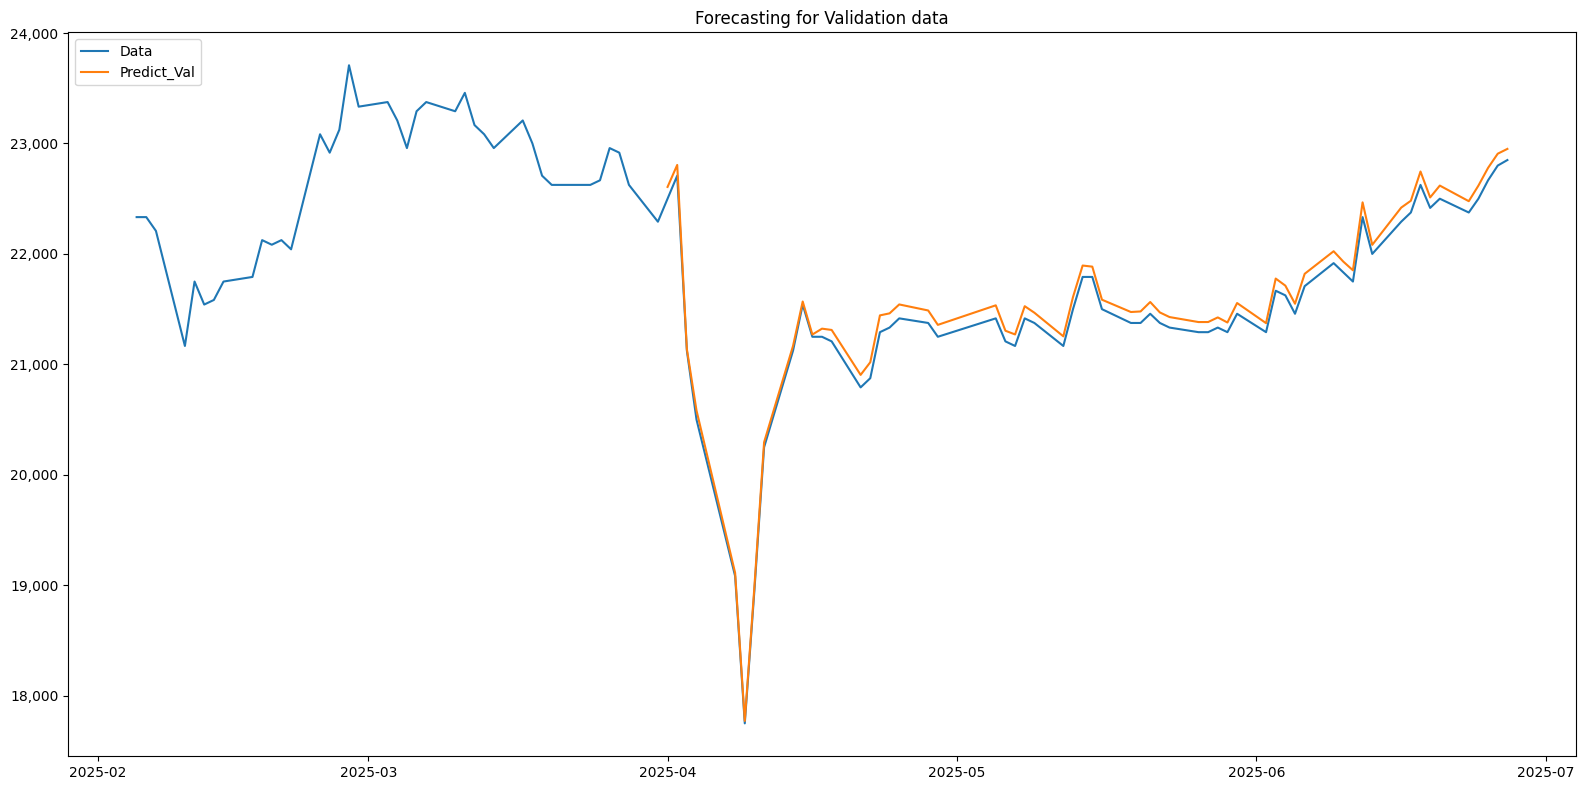

In [ ]:
draw_val(Train_Set, Val_forecast, title  = "Forecasting for Validation data")

In [ ]:
#5.3. Testing Visualise
def draw_fc (Train_Set, Test_Set, fc_result, fc_days, title = "Forecasting for Test data"):
    Train_Set.index = pd.to_datetime(Train_Set.index)
    Test_Set.index = pd.to_datetime(Test_Set.index)
    fc_result.index = pd.to_datetime(fc_result.index)
    Test_Set = Test_Set.iloc[: fc_days]
    line = pd.to_datetime(Train_Set.index[-1], format="%Y-%m-%d")
    new_row = pd.DataFrame(Train_Set['Price'][-1], columns=['Price'], index=[line])
    Test_Set = pd.concat([Test_Set, pd.DataFrame(new_row)], ignore_index=False)
    Test_Set = Test_Set.sort_index()

    plt.figure(figsize = (16,8))
    plt.title(title)
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.plot(Train_Set[-100:])
    plt.plot(Test_Set)
    plt.plot(fc_result['Predictions'].iloc[:fc_days+1])
    plt.legend(['Data_Train','Data_Test','Forecast_Test'], loc ='upper left')
    plt.tight_layout()

    plt.show()

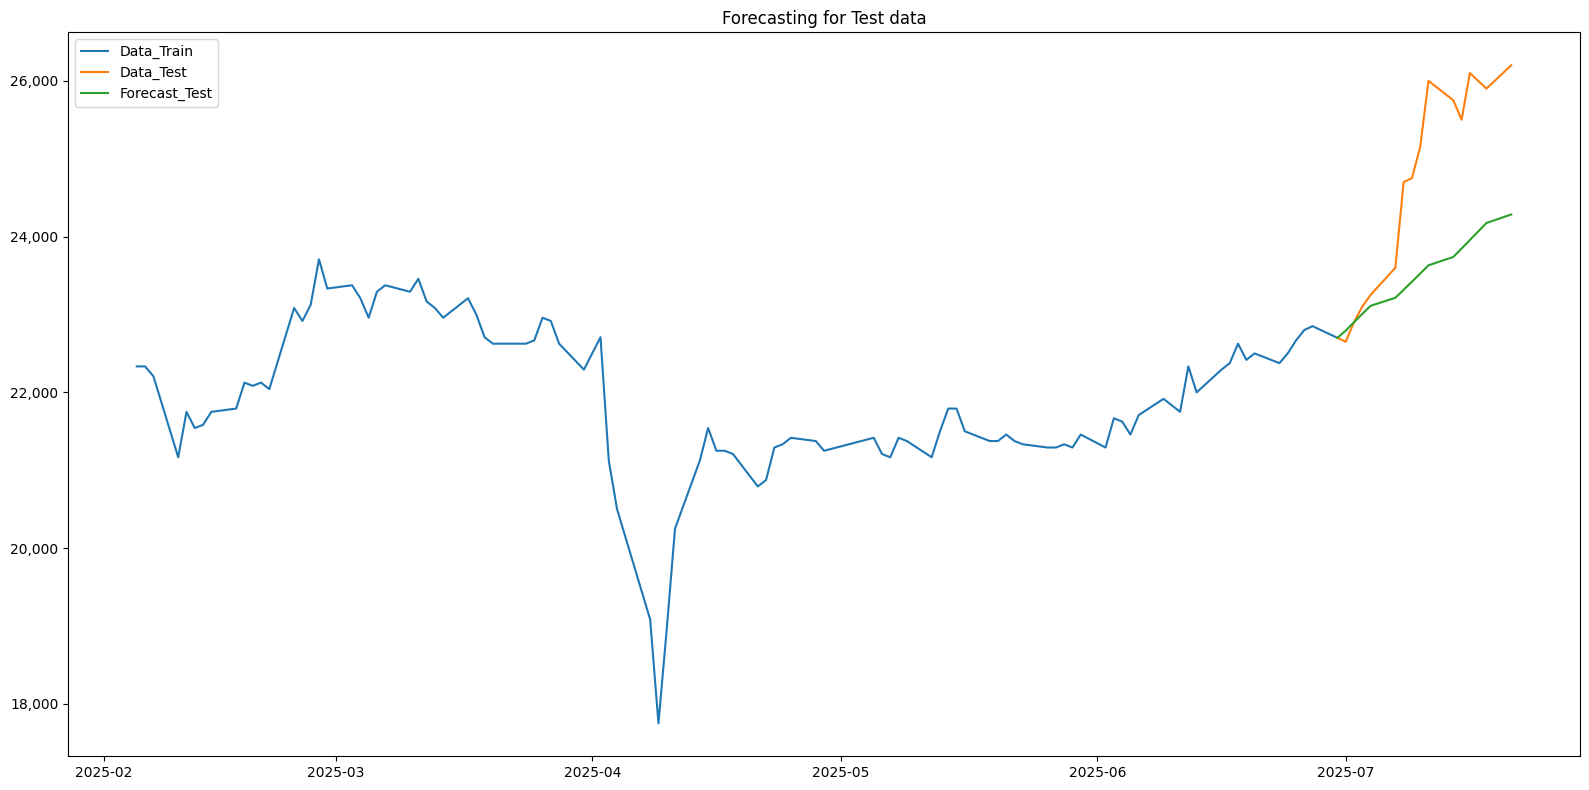

In [ ]:
draw_fc(Train_Set, Test_Set, fc_result = test_forecast, fc_days= 15, title = "Forecasting for Test data")

In [ ]:
#5.4. Loss Function
history.history.keys()

dict_keys(['loss', 'val_loss'])

Text(0.5, 1.0, 'Learning curve')

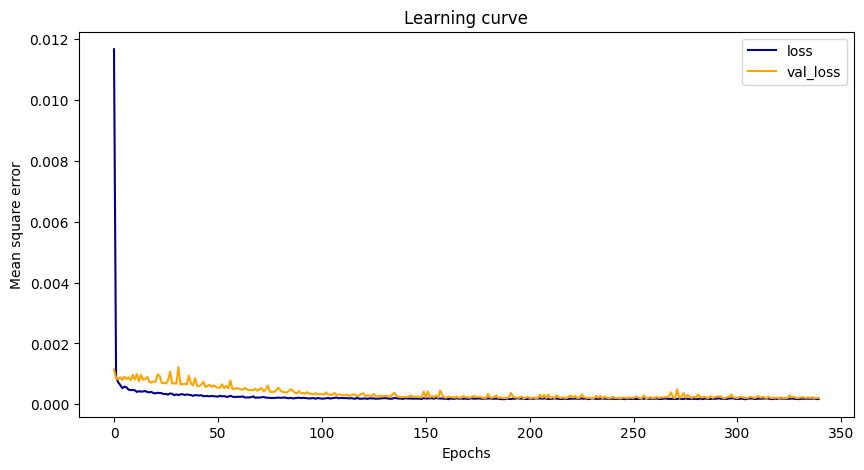

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = 'loss', color = 'darkblue')
plt.plot(history.history['val_loss'], label = 'val_loss', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean square error')
plt.title('Learning curve')

# **IV. Call Back Trained Model for Future Prediction**

In [ ]:
import joblib

time_step = 60
val_days = 60

#Load Model
saved_model = tf.keras.models.load_model("/content/drive/My Drive/Advanced Algorithms - ML/best_model.h5")

#load scaler
scaler = joblib.load('/content/drive/My Drive/Advanced Algorithms - ML/scaler_2.pkl')
Train_Set_scaler=scaler.fit_transform(np.array(Train_Set).reshape(-1,1))
training_size = len(Train_Set) - time_step - val_days
Train_data, Val_data = Train_Set_scaler[0:training_size,:], Train_Set_scaler[training_size::,:1]

#Train and Validation
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
X_train, Y_train = create_dataset(Train_data, time_step)
X_val, Y_val = create_dataset(Val_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)

Train_predict= saved_model.predict(X_train)
Val_predict= saved_model.predict(X_val)
tmp_Val_predict = Val_predict
## Transformback to original form
Train_predict=scaler.inverse_transform(Train_predict)
Val_predict=scaler.inverse_transform(Val_predict)


Val_forecast = Train_Set[-val_days-1:-1].copy()
Val_forecast['Predictions'] = Val_predict

r2 = r2_score(Val_forecast.Price, Val_forecast.Predictions)
rmse = np.sqrt(mean_squared_error(Val_forecast.Price, Val_forecast.Predictions))
mae = mean_absolute_error(Val_forecast.Price, Val_forecast.Predictions)

print(f"✅ R² Score : {r2:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")

# NHÁP

In [ ]:
# @title
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2 = r2_score(Val_forecast.Price, Val_forecast.Predictions)
rmse = np.sqrt(mean_squared_error(Val_forecast.Price, Val_forecast.Predictions))
mae = mean_absolute_error(Val_forecast.Price, Val_forecast.Predictions)

print(f"✅ R² Score : {r2:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")

✅ R² Score : 0.9624
✅ RMSE : 170.0350
✅ MAE : 166.3357


In [ ]:
def draw_val(Train_Set, Val_forecast, title  = "Forecasting for Validation data"):
    Train_Set_Short = Train_Set.iloc[-100:-1]
    plt.figure(figsize = (16,8))
    plt.title(title)
    plt.plot(Train_Set_Short)
    plt.plot(Val_forecast['Predictions'])
    plt.legend(['Data','Predict_Val'], loc ='upper left')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    plt.show()

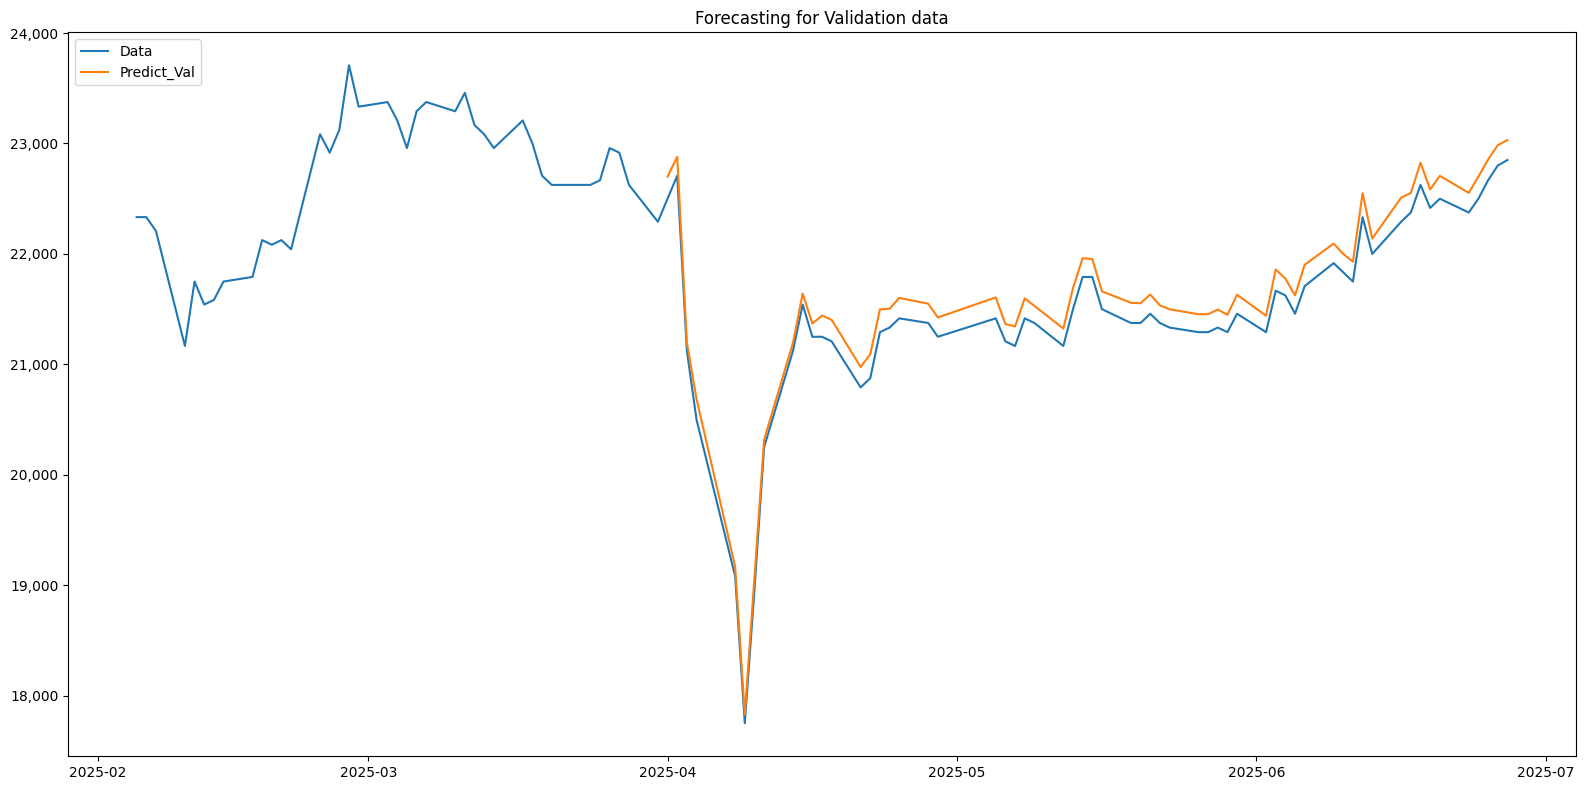

In [ ]:
draw_val(Train_Set, Val_forecast, title  = "Forecasting for Validation data")

In [ ]:
def draw_fc (Train_Set, Test_Set, fc_result, fc_days, title = "Forecasting for Test data"):
    Train_Set.index = pd.to_datetime(Train_Set.index)
    Test_Set.index = pd.to_datetime(Test_Set.index)
    fc_result.index = pd.to_datetime(fc_result.index)
    Test_Set = Test_Set.iloc[: fc_days]
    line = pd.to_datetime(Train_Set.index[-1], format="%Y-%m-%d")
    new_row = pd.DataFrame(Train_Set['Price'][-1], columns=['Price'], index=[line])
    Test_Set = pd.concat([Test_Set, pd.DataFrame(new_row)], ignore_index=False)
    Test_Set = Test_Set.sort_index()

    plt.figure(figsize = (16,8))
    plt.title(title)
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.plot(Train_Set[-100:])
    plt.plot(Test_Set)
    plt.plot(fc_result['Predictions'].iloc[:fc_days+1])
    plt.legend(['Data_Train','Data_Test','Forecast_Test'], loc ='upper left')
    plt.tight_layout()

    plt.show()

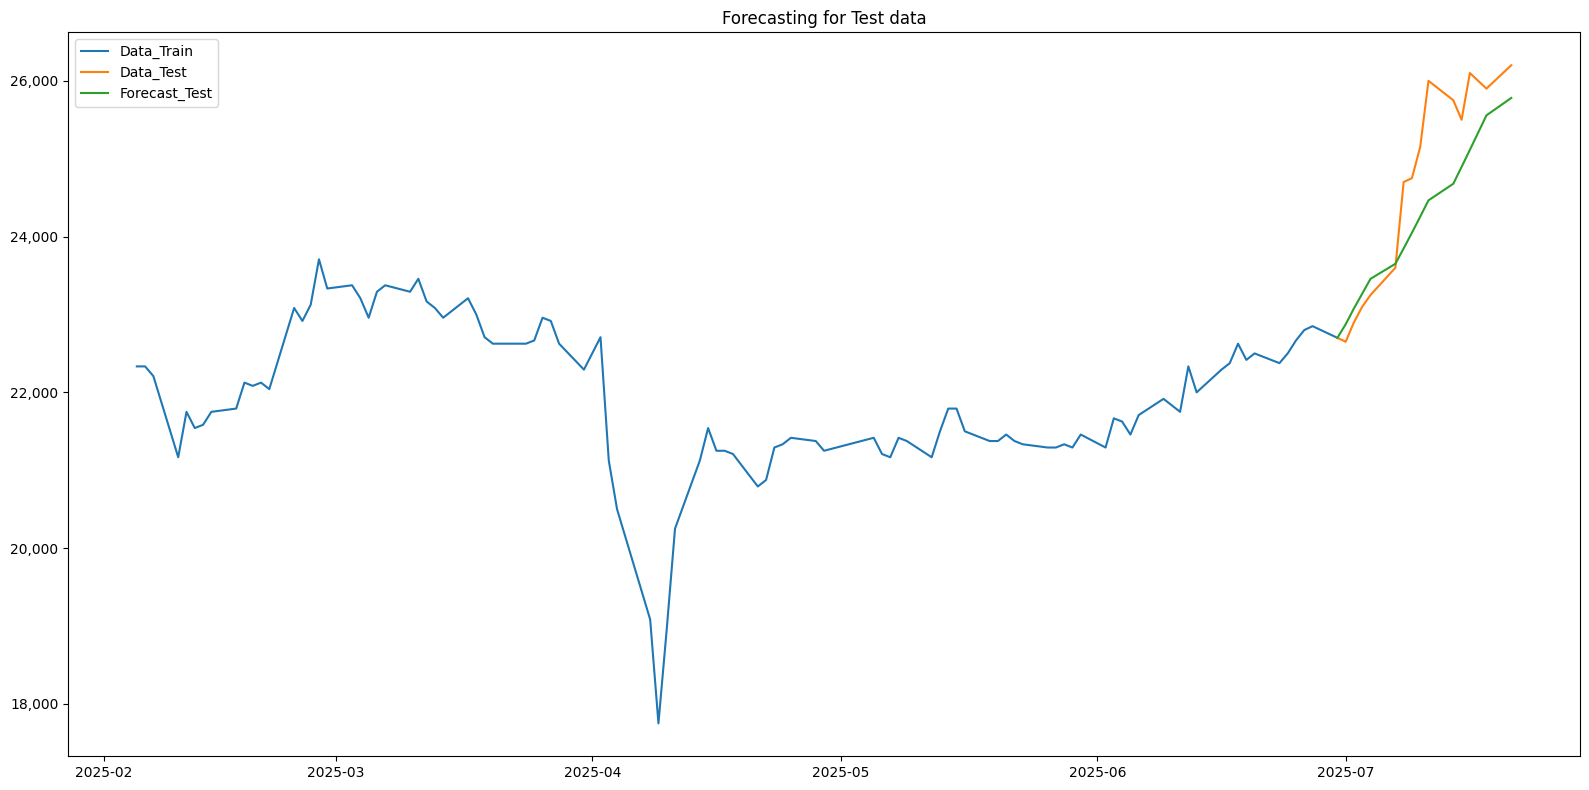

In [ ]:
draw_fc(Train_Set, Test_Set, fc_result = test_forecast, fc_days= 15, title = "Forecasting for Test data")

# **V. LET THE FUN BEGIN: PREDICT & COMPARE REAL DATA FROM 25/9-03/10**

In [ ]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from datetime import timedelta

# Load model & Scaler
saved_model = load_model('/content/drive/MyDrive/LSTM_model/best_model.h5')
scaler = joblib.load("/content/drive/My Drive/Advanced Algorithms - ML/scaler_2.pkl")

# Set up
fc_days = 15
time_step = 60
last_prices = df['Price'][-time_step:]

# Check length
if len(last_prices) < time_step:
    raise ValueError(f"Không đủ {time_step} dòng để dự báo.")

# Scale Value
last_scaled = scaler.transform(np.array(last_prices).reshape(-1, 1))
temp_input = last_scaled.reshape(1, -1).tolist()[0]
output = []

# Prediction Loop
for i in range(fc_days):
    x_input = np.array(temp_input[-time_step:]).reshape(1, time_step, 1)
    yhat = saved_model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    output.append(yhat[0][0])

output = np.array(output).reshape(-1, 1)
output_inv = scaler.inverse_transform(output)

last_date = df.index[-1]  # 2025-09-24
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=fc_days, freq='B')

# Result
forecast_df = pd.DataFrame({'Forecasted Price': output_inv.flatten()}, index=future_dates)
print(forecast_df)


            Forecasted Price
2025-09-25      28921.910156
2025-09-26      28723.193359
2025-09-29      28559.333984
2025-09-30      28414.183594
2025-10-01      28275.570312
2025-10-02      28139.638672
2025-10-03      28004.953125
2025-10-06      27871.228516
2025-10-07      27738.587891
2025-10-08      27607.283203
2025-10-09      27477.574219
2025-10-10      27349.691406
2025-10-13      27223.814453
2025-10-14      27100.076172
2025-10-15      26978.570312


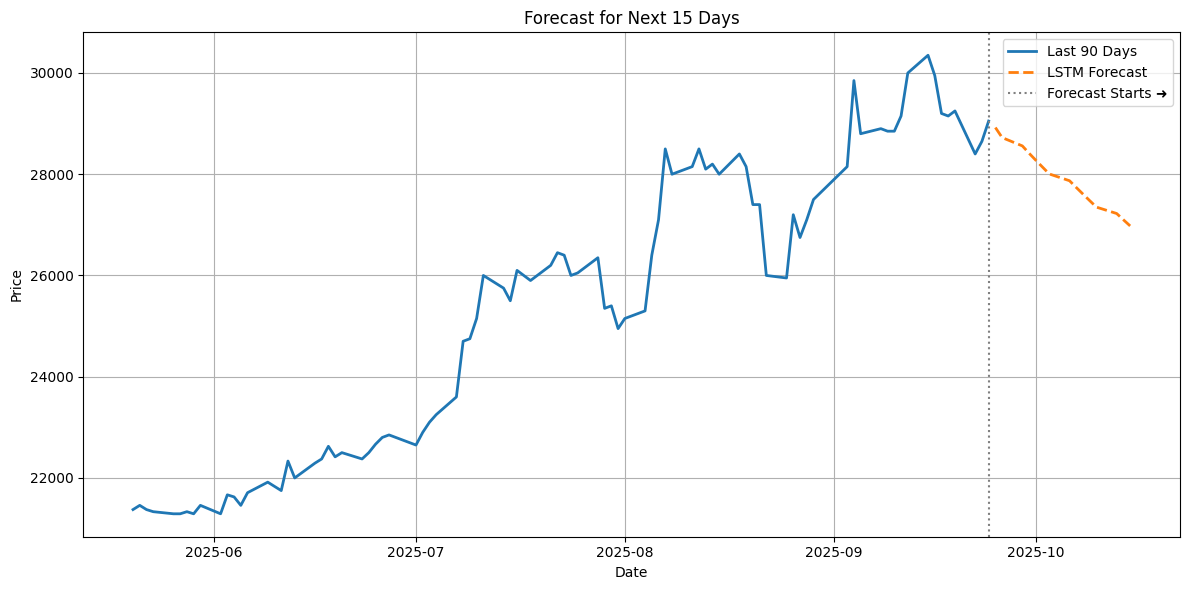

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index[-90:], df['Price'][-90:], label='Last 90 Days', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Forecasted Price'], label='LSTM Forecast', linestyle='--', linewidth=2)
plt.axvline(x=df.index[-1], color='gray', linestyle='dotted', label='Forecast Starts ➜')
plt.title("Forecast for Next 15 Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
actual_df_raw = pd.read_csv("/content/drive/My Drive/Advanced Algorithms - ML/HPG Real Data (2509-0310).csv")
actual_df_raw

,Date,Price,Open,High,Low,Vol.,Change %
0,10/03/2025,"27,650.0","28,100.0","28,100.0","27,350.0",58.12M,-1.60%
1,10/02/2025,"28,100.0","28,350.0","28,650.0","28,050.0",30.17M,-0.71%
2,10/01/2025,"28,300.0","28,300.0","28,500.0","28,100.0",29.85M,0.53%
3,09/30/2025,"28,150.0","28,550.0","28,600.0","27,900.0",53.74M,-1.57%
4,09/29/2025,"28,600.0","28,550.0","28,900.0","28,400.0",38.83M,0.18%
5,09/26/2025,"28,550.0","28,850.0","29,200.0","28,550.0",38.13M,-0.87%
6,09/25/2025,"28,800.0","29,150.0","29,300.0","28,750.0",34.44M,-0.86%


In [ ]:
Data Processing:

#1.1. Covert Date

actual_df_raw["Date"] = pd.to_datetime(actual_df_raw["Date"], errors='coerce')
actual_df_raw = actual_df_raw.dropna(subset=["Date"])
actual_df_raw = actual_df_raw.sort_values("Date")
actual_df_raw = actual_df_raw.set_index("Date")

#========================
#1.2. Covert Numeric Features

cols_numeric = ["Price", "Open", "High", "Low"]

for col in cols_numeric:
    actual_df_raw[col] = (
        actual_df_raw[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("-", "", regex=False)
        .astype(float)
    )

actual_df_raw["Change %"] = (
    actual_df_raw["Change %"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

print(actual_df_raw.dtypes)
print(actual_df_raw.shape)
actual_df_raw

actual_df = actual_df_raw[['Price']]
actual_df

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %    float64
dtype: object
(7, 6)


,Price
Date,
2025-09-25,28800.0
2025-09-26,28550.0
2025-09-29,28600.0
2025-09-30,28150.0
2025-10-01,28300.0
2025-10-02,28100.0
2025-10-03,27650.0


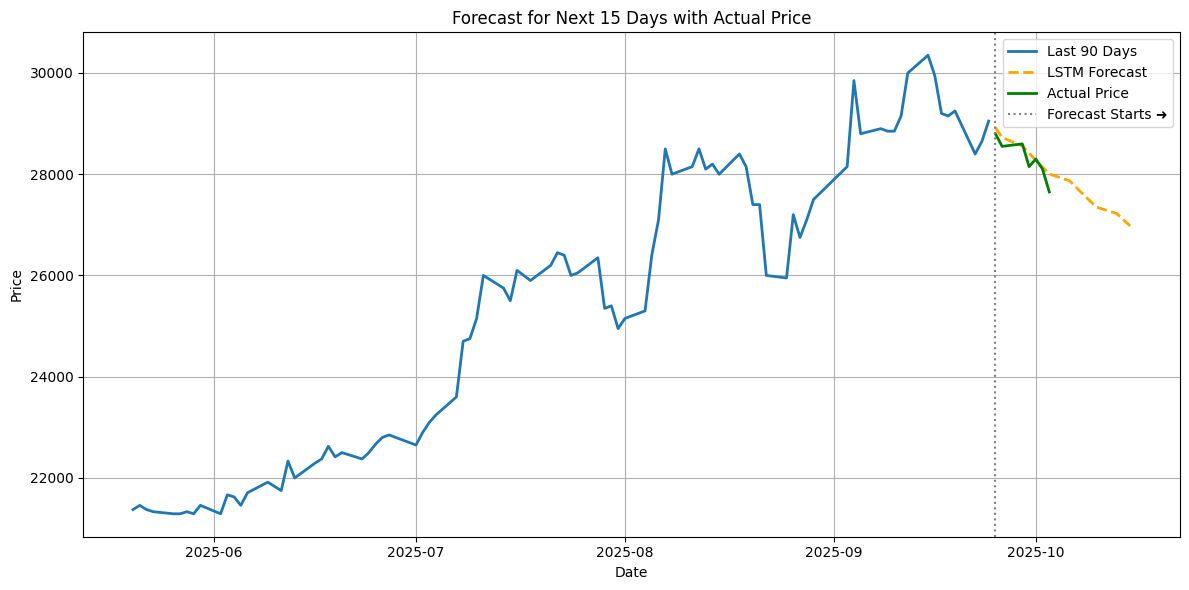

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index[-90:], df['Price'][-90:], label='Last 90 Days', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Forecasted Price'], label='LSTM Forecast', linestyle='--', linewidth=2, color='orange')
plt.plot(actual_df.index, actual_df['Price'], label='Actual Price', linestyle='-', linewidth=2, color='green')
plt.axvline(x=forecast_df.index[0], color='gray', linestyle='dotted', label='Forecast Starts ➜')

plt.title("Forecast for Next 15 Days with Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **[Additional Draft] PREDICTION - RANDOM FOREST MODEL**
I was thinking is there any another advance model that can solve this.

Train: 4313, Validation: 60, Test: 15

📊 Validation (15-day forecast):
R²: -0.4445, RMSE: 942.99, MAE: 686.00, MAPE: 2.56%

📈 Test (15-day forecast):
R²: -0.3320, RMSE: 625.37, MAE: 494.34, MAPE: 1.68%


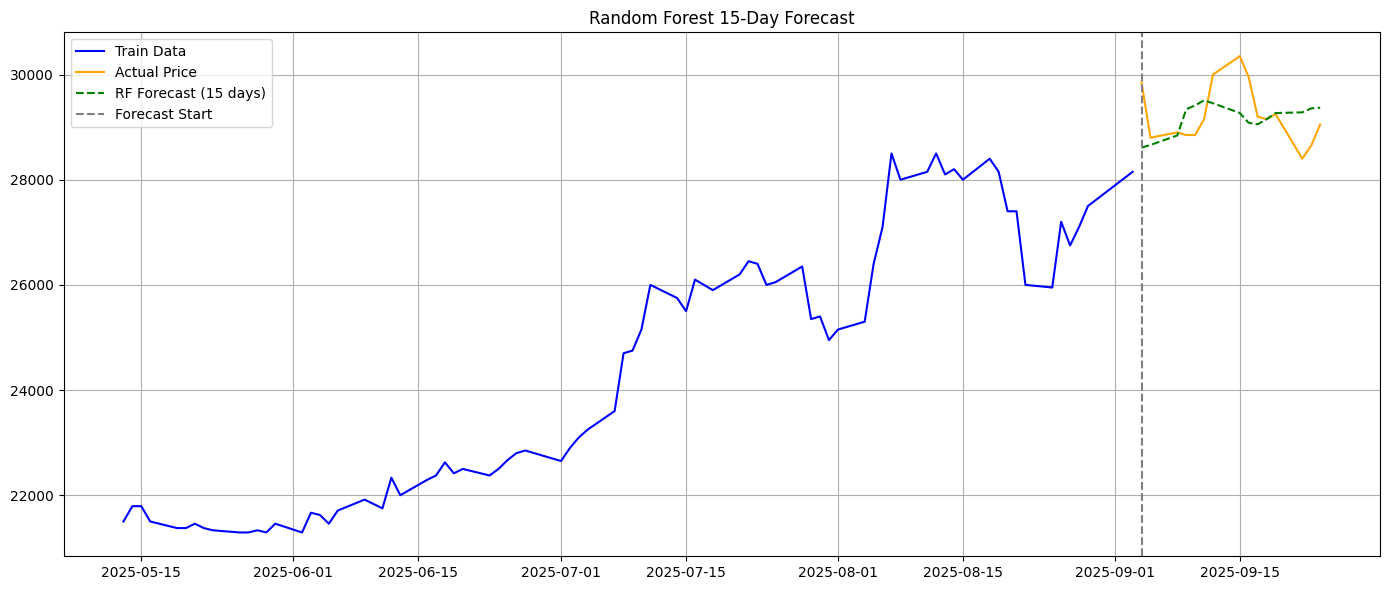

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# ==============================
# 1️⃣ Setup
# ==============================
time_step = 60
val_days = 60
fc_days = 15

scaler = MinMaxScaler()
scaled_price = scaler.fit_transform(df[['Price']])

def create_lag_features(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

X_all, y_all = create_lag_features(scaled_price, time_step)

# ==============================
# 2️⃣ Split Train / Val / Test
# ==============================
train_end = len(X_all) - val_days - fc_days  # train tới trước 60 val + 15 test
val_end = len(X_all) - fc_days

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

# ==============================
# 3️⃣ Train Random Forest
# ==============================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

# ==============================
# 4️⃣ Forecast on Validation (15 days ahead)
# ==============================
val_input = X_val[-1].flatten()  # lấy 60 ngày cuối của val
val_forecast_scaled = []

for _ in range(fc_days):
    yhat_scaled = rf.predict(val_input.reshape(1, -1))
    val_forecast_scaled.append(yhat_scaled[0])
    val_input = np.append(val_input[1:], yhat_scaled)  # dịch cửa sổ lên

val_forecast = scaler.inverse_transform(np.array(val_forecast_scaled).reshape(-1, 1))
y_val_actual = scaler.inverse_transform(y_val[-fc_days:])

rmse_val = np.sqrt(mean_squared_error(y_val_actual, val_forecast))
mae_val = mean_absolute_error(y_val_actual, val_forecast)
mape_val = mean_absolute_percentage_error(y_val_actual, val_forecast) * 100
r2_val = r2_score(y_val_actual, val_forecast)

print("\n📊 Validation (15-day forecast):")
print(f"R²: {r2_val:.4f}, RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}, MAPE: {mape_val:.2f}%")

# ==============================
# 5️⃣ Forecast on Test (15 days ahead)
# ==============================
test_input = X_test[-1].flatten()
test_forecast_scaled = []

for _ in range(fc_days):
    yhat_scaled = rf.predict(test_input.reshape(1, -1))
    test_forecast_scaled.append(yhat_scaled[0])
    test_input = np.append(test_input[1:], yhat_scaled)

test_forecast = scaler.inverse_transform(np.array(test_forecast_scaled).reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test[-fc_days:])

rmse_test = np.sqrt(mean_squared_error(y_test_actual, test_forecast))
mae_test = mean_absolute_error(y_test_actual, test_forecast)
mape_test = mean_absolute_percentage_error(y_test_actual, test_forecast) * 100
r2_test = r2_score(y_test_actual, test_forecast)

print("\n📈 Test (15-day forecast):")
print(f"R²: {r2_test:.4f}, RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, MAPE: {mape_test:.2f}%")

# ==============================
# 6️⃣ Plot Test Forecast
# ==============================
plt.figure(figsize=(14,6))
test_index = df.index[-fc_days:]
plt.plot(df['Price'][-(fc_days+80):-fc_days], label="Train Data", color='blue')
plt.plot(test_index, y_test_actual, label="Actual Price", color='orange')
plt.plot(test_index, test_forecast, label="RF Forecast (15 days)", color='green', linestyle='--')
plt.axvline(x=test_index[0], color='gray', linestyle='--', label='Forecast Start')
plt.title("Random Forest 15-Day Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_price = scaler.fit_transform(data)

# ==============================
# 2️⃣ Create lag features
# ==============================
def create_lag_features(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

time_step = 60
X_all, y_all = create_lag_features(scaled_price, time_step)

# ==============================
# 3️⃣ Define custom 15-day test set
# ==============================
test_start_date = "2025-06-30"
test_days = 15

# Xác định index bắt đầu và kết thúc
test_start_idx = df.index.get_loc(test_start_date)
test_end_idx = test_start_idx + test_days

# Vì có time_step (60), nên X_test sẽ bắt đầu từ (test_start_idx - time_step)
start_idx = test_start_idx - time_step
end_idx = test_end_idx

# Lấy đoạn dữ liệu tương ứng
data_segment = scaled_price[start_idx:end_idx + 1]
X_test, y_test = create_lag_features(data_segment, time_step)

# Tập huấn luyện là toàn bộ dữ liệu trước ngày 30/6/2025
train_mask = df.index < test_start_date
train_data = scaled_price[train_mask]
X_train, y_train = create_lag_features(train_data, time_step)

# ==============================
# 4️⃣ Train Random Forest
# ==============================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

# ==============================
# 5️⃣ Predict and evaluate
# ==============================
y_pred_scaled = rf.predict(X_test.reshape(X_test.shape[0], -1)).reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Get corresponding date range for 15 days
dates = df.index[test_start_idx:test_start_idx + len(y_pred)]

In [ ]:
# 6️⃣ Evaluation metrics

r2 = r2_score(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100

print(f"Random Forest 15-day Forecast Results:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


Random Forest 15-day Forecast Results:
R² Score: 0.815
RMSE: 570.89
MAE: 453.21
MAPE: 1.82%


In [ ]:
import numpy as np
import pandas as pd

def build_rf_fc_result(df, test_start_date, y_pred, fc_days):
    """
    Make Train_Set_RF, Test_Set_RF and fc_result so that:
      - Test_Set_RF has exactly fc_days prices (future window)
      - fc_result has fc_days + 1 rows: [last_train_point] + [fc_days forecasts]
        (this matches your draw_fc() which plots [:fc_days+1])
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Split train/test windows by date
    Train_Set_RF = df[df.index < test_start_date][['Price']].copy()
    Test_Set_RF  = df[df.index >= test_start_date][['Price']].iloc[:fc_days].copy()

    # Forecast dates = exactly the dates in Test_Set_RF
    fc_idx = Test_Set_RF.index

    # Ensure y_pred length matches fc_days
    y_pred = np.asarray(y_pred).reshape(-1)[:len(fc_idx)]

    # Build forecast df and prepend the last train point (like your LSTM code)
    last_date  = Train_Set_RF.index[-1]
    last_price = Train_Set_RF['Price'].iloc[-1]

    fc_result = pd.DataFrame({'Predictions': y_pred}, index=fc_idx)
    last_row  = pd.DataFrame({'Predictions': [last_price]}, index=[last_date])
    fc_result = pd.concat([last_row, fc_result]).sort_index()

    return Train_Set_RF, Test_Set_RF, fc_result


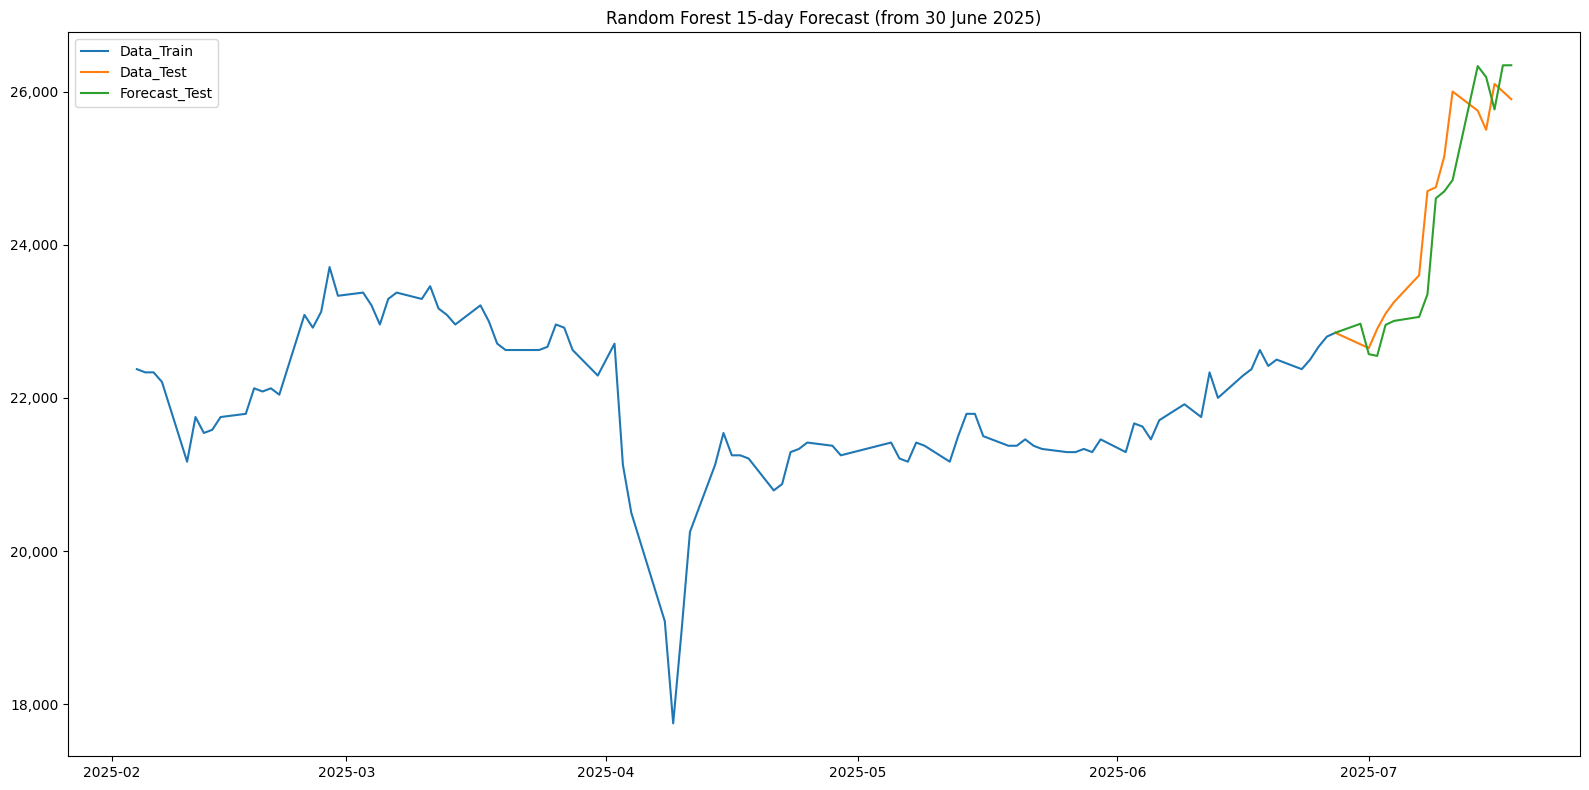

In [ ]:
# y_pred từ RandomForest đã tính ở trên (shape (15, 1) hoặc (15,))
fc_days = 15
Train_Set_RF, Test_Set_RF, fc_result_RF = build_rf_fc_result(
    df=df,
    test_start_date="2025-06-30",
    y_pred=y_pred,            # dự báo RF của bạn
    fc_days=fc_days
)

# Dùng lại y nguyên hàm draw_fc() của bạn:
draw_fc(
    Train_Set=Train_Set_RF,
    Test_Set=Test_Set_RF,
    fc_result=fc_result_RF,   # đã có last-train + 15 ngày dự báo
    fc_days=fc_days,
    title="Random Forest 15-day Forecast (from 30 June 2025)"
)
